<a href="https://colab.research.google.com/github/songaong8006/shoes_classifier/blob/main/for_new_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install azure-cognitiveservices-search-imagesearch
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 51kB 3.6MB/s 
     |████████████████████████████████| 92kB 6.1MB/s 
     |████████████████████████████████| 40kB 4.6MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 2.6MB 9.8MB/s 
     |████████████████████████████████| 727kB 7.4MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 16.6MB/s 
     |████████████████████████████████| 194kB 37.8MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
Mounted at /content/gdrive


In [6]:
from utils import *
from fastbook import *
from fastai.vision.widgets import *


 Download of https://www.omegasports.com/prodimages/5479-DEFAULT-L.jpg has failed after 5 retries
 Fix the download manually:
$ mkdir -p shoes/adidas
$ cd shoes/adidas
$ wget -c https://www.omegasports.com/prodimages/5479-DEFAULT-L.jpg
$ tar xf 5479-DEFAULT-L.jpg
 And re-run your code once the download is successful



In [7]:
fns = get_image_files(data_path)
fns

(#1200) [Path('shoes/adidas/00000140.JPG'),Path('shoes/adidas/00000079.jpg'),Path('shoes/adidas/00000211.jpg'),Path('shoes/adidas/00000352.jpg'),Path('shoes/adidas/00000321.jpg'),Path('shoes/adidas/00000102.jpg'),Path('shoes/adidas/00000012.jpg'),Path('shoes/adidas/00000048.jpg'),Path('shoes/adidas/00000413.jpg'),Path('shoes/adidas/00000351.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#51) [Path('shoes/adidas/00000173.jpg'),Path('shoes/adidas/00000210.jpg'),Path('shoes/adidas/00000390.jpg'),Path('shoes/adidas/00000327.jpg'),Path('shoes/adidas/00000292.jpg'),Path('shoes/adidas/00000161.jpg'),Path('shoes/adidas/00000170.jpg'),Path('shoes/adidas/00000092.jpg'),Path('shoes/adidas/00000182.jpg'),Path('shoes/adidas/00000117.jpg')...]

In [10]:
failed.map(Path.unlink);

In [11]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = shoes.dataloaders(data_path)

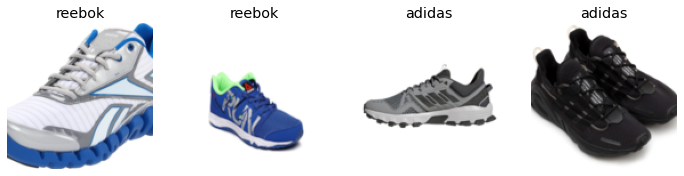

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

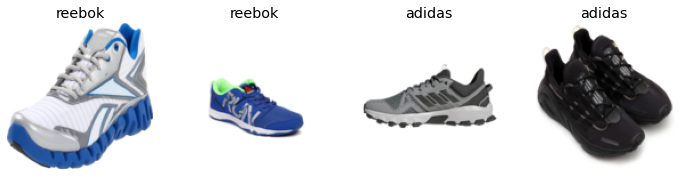

In [14]:
shoes = shoes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = shoes.dataloaders(data_path)
dls.valid.show_batch(max_n=4, nrows=1)

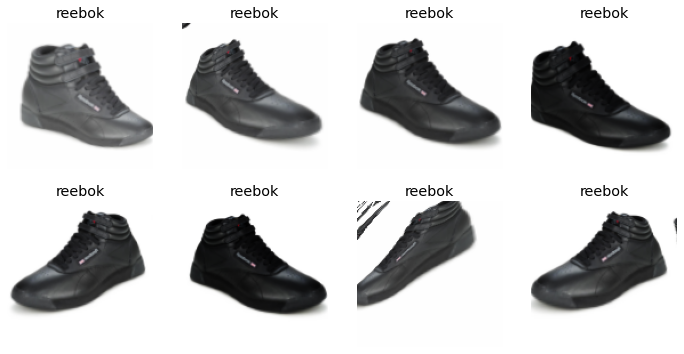

In [15]:
shoes = shoes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = shoes.dataloaders(data_path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(data_path)

In [17]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.778421,0.993260,0.371179,02:42


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,1.133255,0.751524,0.310044,03:22
1,0.961394,0.779902,0.248908,03:22
2,0.784451,0.740522,0.227074,03:23
3,0.680430,0.699735,0.209607,03:24


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


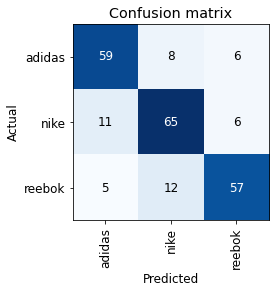

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

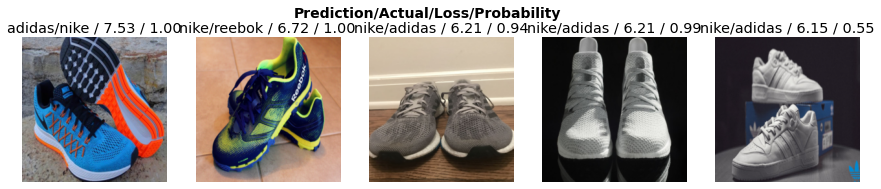

In [19]:
interp.plot_top_losses(5, nrows=1)

In [20]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
learn.export()

In [22]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [23]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('shoes/nike/00000321.jpg')

('nike', tensor(1), tensor([0.0293, 0.8982, 0.0725]))

In [31]:
learn_inf.dls.vocab

['adidas', 'nike', 'reebok']

In [32]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
path = Path()
learn_inf = load_learner(path/'export.pkl', cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [35]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [36]:
btn_upload.observe(on_data_change, names=['data'])

In [37]:
display(VBox([widgets.Label('Select your bear!'), btn_upload, out_pl, lbl_pred]))